<a href="https://colab.research.google.com/github/EniolaWebsterEsho/Prediction-Codes/blob/main/Prediction_of_Surface_Water_Discharge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Importing the Libraries**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dropout, Dense


### **Loading the Data**

In [2]:
from google.colab import files
uploaded = files.upload()

Saving USGS Birmingham Alabama.csv to USGS Birmingham Alabama.csv


The dataset is available at USGS Website

In [3]:
df = pd.read_csv('USGS Birmingham Alabama.csv', parse_dates=True)
df.head()

,agency_cd,site_no,timestamp,Gage Height,Discharge
0,USGS,2461130,01/10/2021 00:00,1.55,9.69
1,USGS,2461130,01/10/2021 00:05,1.55,9.69
2,USGS,2461130,01/10/2021 00:10,1.55,9.69
3,USGS,2461130,01/10/2021 00:15,1.55,9.69
4,USGS,2461130,01/10/2021 00:20,1.55,9.69


### **Data Cleaning**

In [4]:
df.describe()

,site_no,Gage Height,Discharge
count,26460.0,26460.000000,26460.000000
mean,2461130.0,1.662526,29.861166
std,0.0,0.557989,154.493393
min,2461130.0,1.480000,6.750000
25%,2461130.0,1.530000,9.460000
50%,2461130.0,1.560000,10.700000
75%,2461130.0,1.600000,13.700000
max,2461130.0,12.320000,3920.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26460 entries, 0 to 26459
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   agency_cd    26460 non-null  object 
 1   site_no      26460 non-null  int64  
 2   timestamp    26460 non-null  object 
 3   Gage Height  26460 non-null  float64
 4   Discharge    26460 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.0+ MB


In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['Year'] = df.timestamp.dt.year
df['Month'] = df.timestamp.dt.month
df.head()

,agency_cd,site_no,timestamp,Gage Height,Discharge,Year,Month
0,USGS,2461130,2021-01-10 00:00:00,1.55,9.69,2021,1
1,USGS,2461130,2021-01-10 00:05:00,1.55,9.69,2021,1
2,USGS,2461130,2021-01-10 00:10:00,1.55,9.69,2021,1
3,USGS,2461130,2021-01-10 00:15:00,1.55,9.69,2021,1
4,USGS,2461130,2021-01-10 00:20:00,1.55,9.69,2021,1


In [10]:
MinMax_scaler = preprocessing.MinMaxScaler()
scaled_data = MinMax_scaler.fit_transform(df[['Gage Height', 'Year','Month', 'Discharge']])

In [11]:
scaled_df = df.copy()
scaled_df['Gage Height'] = scaled_data[:, 0]
scaled_df['Year'] = scaled_data[:, 1]
scaled_df['Month'] = scaled_data[:, 2]
scaled_df['Discharge'] = scaled_data[:, 3]
scaled_df.head()

,agency_cd,site_no,timestamp,Gage Height,Discharge,Year,Month
0,USGS,2461130,2021-01-10 00:00:00,0.006458,0.000751,0.0,0.0
1,USGS,2461130,2021-01-10 00:05:00,0.006458,0.000751,0.0,0.0
2,USGS,2461130,2021-01-10 00:10:00,0.006458,0.000751,0.0,0.0
3,USGS,2461130,2021-01-10 00:15:00,0.006458,0.000751,0.0,0.0
4,USGS,2461130,2021-01-10 00:20:00,0.006458,0.000751,0.0,0.0


### **Splitting the Data**

In [12]:
time_step = 1

In [13]:
training_size = int(len(scaled_df) * 0.9)
training, testing = scaled_df[0:training_size], scaled_df[training_size:len(df)]
print('size of the dataset: %d' % (len(scaled_df)))
print('Training examples: %d' % (len(training)))
print('size of the test dataset: %d' % (len(testing)))

size of the dataset: 26460
Training examples: 23814
size of the test dataset: 2646


In [14]:
x_train = training[['Gage Height','Year','Month','Discharge']].to_numpy()
y_train = scaled_df[time_step:testing.index[0]]['Discharge'].to_numpy()

In [15]:
x_test = testing[0:-time_step][['Gage Height','Year','Month','Discharge']].to_numpy()
y_test = scaled_df[testing.index[0] + time_step:]['Discharge'].to_numpy()

In [16]:
x_train.shape

(23814, 4)

In [17]:
x_test.shape

(2645, 4)

### **Building the Model**

In [18]:
def create_sequence(dataset, length):
    data_sequences = []
    for index in range(len(dataset) - length):
        data_sequences.append(dataset[index: index + length])
    return np.asanyarray(data_sequences)

In [19]:
X_train = create_sequence(x_train, 48)
X_test = create_sequence(x_test, 48)
y_train = y_train[-X_train.shape[0]:]
y_test = y_test[-X_test.shape[0]:]

In [20]:
print("X_train shape = {}, and y_train shape={}".format(X_train.shape, y_train.shape))

X_train shape = (23766, 48, 4), and y_train shape=(23766,)


In [21]:
print("X_train shape = {}, and y_train shape={}".format(X_train.shape, y_train.shape))

X_train shape = (23766, 48, 4), and y_train shape=(23766,)


In [22]:
import tensorflow as tf
from tensorflow import keras

In [23]:
X_train.shape[1]

48

In [24]:
X_train.shape[-1]

4

In [25]:
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True, dropout= 0.5, input_shape =(X_train.shape[1], X_train.shape[-1]))))
model.add(Bidirectional(LSTM(20, dropout=0.5)))
model.add(Dense(1))
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mse', optimizer=opt)

### **Training and Testing**

In [26]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_split = 0.33)

Epoch 1/10
125/125 [==============================] - 34s 193ms/step - loss: 0.0114 - val_loss: 6.8844e-05
Epoch 2/10
125/125 [==============================] - 23s 184ms/step - loss: 4.8111e-04 - val_loss: 6.2256e-05
Epoch 3/10
125/125 [==============================] - 22s 178ms/step - loss: 3.4976e-04 - val_loss: 5.6016e-05
Epoch 4/10
125/125 [==============================] - 22s 177ms/step - loss: 3.7476e-04 - val_loss: 5.3048e-05
Epoch 5/10
125/125 [==============================] - 23s 186ms/step - loss: 3.3768e-04 - val_loss: 6.7102e-05
Epoch 6/10
125/125 [==============================] - 22s 177ms/step - loss: 3.2842e-04 - val_loss: 5.0694e-05
Epoch 7/10
125/125 [==============================] - 22s 178ms/step - loss: 3.1237e-04 - val_loss: 4.9141e-05
Epoch 8/10
125/125 [==============================] - 22s 179ms/step - loss: 3.3818e-04 - val_loss: 5.1579e-05
Epoch 9/10
125/125 [==============================] - 22s 177ms/step - loss: 2.8736e-04 - val_loss: 7.1697e-05
Epoch

In [27]:
predictions = history.model.predict(X_test)

In [28]:
def evaluate_predictions(predictions, y_test, outliers):
    ratio = []
    differences = []
    for pred in range (len(y_test)):
        ratio.append((y_test[pred]/predictions[pred])-1)
        differences.append(y_test[pred] - predictions[pred]) 

    n_outliers = int(len(differences) * outliers)
    outliers = pd.Series(differences).astype(float).nlargest(n_outliers)

    return ratio, differences, outliers

In [29]:
ratio, differences, outliers = evaluate_predictions(predictions, y_test, 0.01)

In [30]:
#index of outliers
for index in outliers.index:
    outliers[index] = predictions[index]
outliers

2097    0.449104
2096    0.420675
2098    0.483549
2091    0.140589
2090    0.070060
2095    0.397910
2092    0.232101
2094    0.366110
2093    0.312287
2099    0.513822
2089    0.031046
2100    0.518490
2088    0.025911
1780    0.013989
1781    0.037253
1786    0.135232
1785    0.123317
1787    0.152262
1782    0.069192
2060    0.018719
2101    0.502664
1779    0.010205
1784    0.113498
1783    0.096287
2059    0.014454
dtype: float64

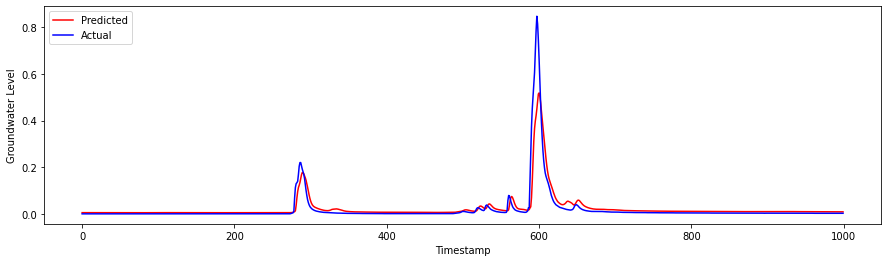

In [32]:
fig, axs = pyplot.subplots()
fig.set_figheight(4)
fig.set_figwidth(15)
axs.plot(predictions[1500:2500,], color='red', label='Predicted')
axs.plot(y_test[1500:2500,], color='blue', label='Actual')
pyplot.xlabel('Timestamp')
pyplot.ylabel('Groundwater Level')
pyplot.legend(loc='upper left')
pyplot.show()

Performining inverse transform

In [35]:
x_train_df = pd.DataFrame(x_train, columns = ['Gage Height', 'Month','Year', 'Discharge'])
x_train_df = x_train_df[0:23766]

In [36]:
inverse_x_train = MinMax_scaler.inverse_transform(x_train_df[['Gage Height', 'Year','Month', 'Discharge']])
#inverse_y_train = MinMax_scaler.inverse_transform(x_train_df[['Gage Height', 'Year', 'Month','y_train']])

In [37]:
x_test_df = pd.DataFrame(x_test, columns = ['Gage Height', 'Month','Year', 'Discharge'])
x_test_df = x_test_df[0:2597]

In [38]:
x_test_df['predictions'] = predictions
x_test_df['y_test'] = y_test

In [39]:
inverse = MinMax_scaler.inverse_transform(x_test_df[['Gage Height', 'Year','Month', 'y_test']])
inverse2 = MinMax_scaler.inverse_transform(x_test_df[['Gage Height', 'Year', 'Month', 'predictions']])
#inverse3 = MinMax_scaler.inverse_transform(x_test_df[['Gage Height', 'Year', 'Month', 'Discharge']])

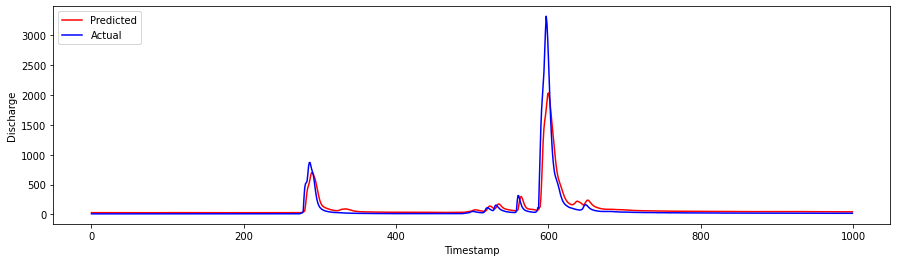

In [40]:
fig, axs = pyplot.subplots()
fig.set_figheight(4)
fig.set_figwidth(15)
axs.plot(inverse2[1500:2500,3], color='red', label='Predicted')
axs.plot(inverse[1500:2500,3], color='blue', label='Actual')
pyplot.xlabel('Timestamp')
pyplot.ylabel('Discharge')
pyplot.legend(loc='upper left')
pyplot.show()

### **Evaluation of Model**

In [41]:
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
mape = sqrt(mean_absolute_percentage_error(y_test, predictions))
print(mape)

2.223542801999169


In [42]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = sqrt(mean_squared_error(y_test, predictions))
print(mse)

0.022093664970265554
